Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
# from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128
regularization = 0.01

graph = tf.Graph()

with graph.as_default():
  # Data
  X_train = tf.placeholder(dtype=tf.float32, shape=[batch_size, image_size*image_size])
  y_train = tf.placeholder(dtype=tf.float32, shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(dtype=tf.float32)

  # Parameters
  weights = tf.Variable(
    tf.truncated_normal(shape=[image_size*image_size, num_labels]))
  bias = tf.Variable(tf.zeros(shape=[num_labels]))
  
  # Logits and Loss
  logits = tf.matmul(X_train, weights) + bias 
  loss = tf.nn.softmax_cross_entropy_with_logits(logits, y_train)
  
  # Reguularization
  loss += beta * tf.nn.l2_loss(weights)
  loss = tf.reduce_mean(loss)
  
  # Optimizer
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  train_pred = tf.nn.softmax(logits)
  val_pred = tf.nn.softmax(tf.matmul(X_val, weights) + bias)
  test_pred = tf.nn.softmax(tf.matmul(X_test, weights) + bias)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta:regularization}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))

Initialized
Minibatch loss at step 0: 47.936279
Minibatch accuracy: 6.2%
Validation accuracy: 13.1%
Minibatch loss at step 500: 0.866828
Minibatch accuracy: 83.6%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 0.685021
Minibatch accuracy: 85.2%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.794337
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 0.811118
Minibatch accuracy: 80.5%
Validation accuracy: 81.8%
Minibatch loss at step 2500: 0.930531
Minibatch accuracy: 78.1%
Validation accuracy: 81.9%
Minibatch loss at step 3000: 0.945361
Minibatch accuracy: 76.6%
Validation accuracy: 81.7%
Test accuracy: 88.8%


#### Plot Test Accuracy by L2 Regularization

In [116]:
reg = [pow(10, i) for i in np.arange(-4, -1, 0.1)]
accuracies = list()

for regularization in reg:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {X_train : batch_data, y_train : batch_labels, beta: regularization}
      _, l, predictions = session.run(
        [optimizer, loss, train_pred], feed_dict=feed_dict)
    
    accuracies.append(accuracy(val_pred.eval(), valid_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


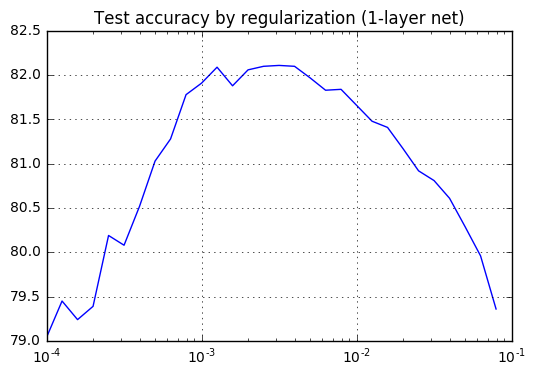

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(reg, accuracies)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

In [33]:
num_hidden = 1024
beta = 1e-3

graph = tf.Graph()

with graph.as_default():
  
  # Input data
  X_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, image_size*image_size])
  y_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  
  # parameters 
  weights_input = tf.Variable(
    tf.truncated_normal(shape=[image_size*image_size, num_hidden]))
  bias = tf.Variable(tf.zeros(shape=[num_hidden]))
  weights_hidden = tf.Variable(tf.truncated_normal(shape=[num_hidden, num_labels]))
  bias2 = tf.Variable(tf.zeros(shape=[num_labels]))
  
  # Logits, ReLU and Loss
  logits_input = tf.matmul(X_train, weights_input) + bias
  relu_input = tf.nn.relu(logits_input)
  logits_hidden = tf.matmul(relu_input, weights_hidden) + bias2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_hidden, y_train))
  
  # Add regularization
  loss += beta * (tf.nn.l2_loss(weights_input) + tf.nn.l2_loss(weights_hidden))
  #loss = tf.reduce_mean(loss)
  
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predict
  train_pred = tf.nn.softmax(logits_hidden)
  val_layer1 = tf.nn.relu(tf.matmul(X_val, weights_input) + bias)
  val_pred = tf.nn.softmax(tf.matmul(val_layer1, weights_hidden) + bias2)
  test_layer1 = tf.nn.relu(tf.matmul(X_test, weights_input) + bias)
  test_pred = tf.nn.softmax(tf.matmul(test_layer1, weights_hidden) + bias2)

In [34]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))

Initialized
Minibatch loss at step 0: 638.656250
Minibatch accuracy: 7.8%
Validation accuracy: 33.0%
Minibatch loss at step 500: 194.389755
Minibatch accuracy: 82.8%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 113.787880
Minibatch accuracy: 82.0%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 68.882332
Minibatch accuracy: 85.9%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 41.441406
Minibatch accuracy: 85.9%
Validation accuracy: 85.1%
Minibatch loss at step 2500: 25.332434
Minibatch accuracy: 82.0%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 15.577061
Minibatch accuracy: 85.2%
Validation accuracy: 86.7%
Test accuracy: 93.1%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
batch_size = 128
num_batches = 3
num_steps = 50

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 5 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))

Initialized
Minibatch loss at step 0: 662.872803
Minibatch accuracy: 12.5%
Validation accuracy: 33.5%
Minibatch loss at step 5: 354.853088
Minibatch accuracy: 89.8%
Validation accuracy: 64.6%
Minibatch loss at step 10: 311.934479
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 15: 310.378815
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 20: 308.828796
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 25: 307.287506
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 30: 305.756470
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 35: 304.228821
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 40: 302.712494
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 45: 301.202484
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Test accuracy: 71.8%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [29]:
num_hidden = 1024


graph = tf.Graph()

with graph.as_default():
  
  # Input data
  X_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, image_size*image_size])
  y_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  
  # parameters 
  weights_input = tf.Variable(
    tf.truncated_normal(shape=[image_size*image_size, num_hidden]))
  bias = tf.Variable(tf.zeros(shape=[num_hidden]))
  weights_hidden = tf.Variable(tf.truncated_normal(shape=[num_hidden, num_labels]))
  bias2 = tf.Variable(tf.zeros(shape=[num_labels]))
  
  # Logits, ReLU and Loss
  logits_input = tf.matmul(X_train, weights_input) + bias
  relu_input = tf.nn.relu(logits_input)
  relu_input = tf.nn.dropout(relu_input, 0.5)
  logits_hidden = tf.matmul(relu_input, weights_hidden) + bias2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_hidden, y_train))
  
  # Add regularization
  loss += beta * (tf.nn.l2_loss(weights_input) + tf.nn.l2_loss(weights_hidden))
#  loss = tf.reduce_mean(loss)
  
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predict
  train_pred = tf.nn.softmax(logits_hidden)
  val_layer1 = tf.nn.relu(tf.matmul(X_val, weights_input) + bias)
  val_pred = tf.nn.softmax(tf.matmul(val_layer1, weights_hidden) + bias2)
  test_layer1 = tf.nn.relu(tf.matmul(X_test, weights_input) + bias)
  test_pred = tf.nn.softmax(tf.matmul(test_layer1, weights_hidden) + bias2)
  
batch_size = 128
num_batches = 3
num_steps = 50

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 5 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))

Initialized
Minibatch loss at step 0: 774.546875
Minibatch accuracy: 11.7%
Validation accuracy: 26.3%
Minibatch loss at step 5: 374.047516
Minibatch accuracy: 79.7%
Validation accuracy: 61.9%
Minibatch loss at step 10: 316.102295
Minibatch accuracy: 96.1%
Validation accuracy: 67.1%
Minibatch loss at step 15: 311.028229
Minibatch accuracy: 99.2%
Validation accuracy: 68.3%
Minibatch loss at step 20: 309.446747
Minibatch accuracy: 100.0%
Validation accuracy: 68.9%
Minibatch loss at step 25: 308.921173
Minibatch accuracy: 98.4%
Validation accuracy: 68.6%
Minibatch loss at step 30: 307.397125
Minibatch accuracy: 98.4%
Validation accuracy: 68.2%
Minibatch loss at step 35: 305.901306
Minibatch accuracy: 99.2%
Validation accuracy: 68.7%
Minibatch loss at step 40: 303.539581
Minibatch accuracy: 99.2%
Validation accuracy: 68.5%
Minibatch loss at step 45: 301.870453
Minibatch accuracy: 100.0%
Validation accuracy: 68.5%
Test accuracy: 74.5%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [23]:
num_hidden1 = 1024
batch_size = 128
image_size = 28
num_labels = 10

graph = tf.Graph()

with graph.as_default():
  X_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, image_size**2])
  y_train = tf.placeholder(dtype=tf.float32, 
                          shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(dtype=tf.float32)
  
  
  # Parameters
  # Input layer
  weights_input = tf.Variable(
    tf.truncated_normal(shape=[image_size**2, num_hidden1]))
  bias_to_hidden1 = tf.Variable(tf.zeros(shape=[num_hidden1]))
  
  # 1st hidden layer
  weights_hidden1 = tf.Variable(
    tf.truncated_normal([num_hidden1, num_labels]))
  bias_to_output = tf.Variable(tf.zeros([num_labels]))
  
  # Compute Logits, ReLU, Dropout
  logits_input = tf.nn.relu(tf.matmul(X_train, weights_input) + bias_to_hidden1)
  # Dropout
  logits_input = tf.nn.dropout(logits_input, 0.5)
  
  final_logits = tf.matmul(logits_input, weights_hidden1) + bias_to_output
  
  # Comput Cross entropy
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(final_logits, y_train))
  
  # Add Regularization
  loss += beta * ( tf.nn.l2_loss(weights_input) + 
                  tf.nn.l2_loss(weights_hidden1))
  
  # Optimizer
  optimizer = tf.train.GradientDescentOptimizer(0.25).minimize(loss)
  
  # Predict
  train_pred = tf.nn.softmax(final_logits)
  val_layer1 = tf.nn.relu(tf.matmul(X_val, weights_input) + bias_to_hidden1)
  val_pred = tf.nn.softmax(tf.matmul(val_layer1, weights_hidden1) + bias_to_output)
  test_layer1 = tf.nn.relu(tf.matmul(X_test, weights_input) + bias_to_hidden1)
  test_pred = tf.nn.softmax(tf.matmul(test_layer1, weights_hidden1) + bias_to_output)

In [25]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick offset 
    items = np.random.randint(0, train_dataset.shape[0], batch_size)
    # Generate minibatch
    batch_data = train_dataset[items,:]
    batch_labels = train_labels[items,:]
    # Prepare dict telling the session where to feed the minibatch.
    # Key of dict is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed it
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f'% (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 767.271484
Minibatch accuracy: 13.3%
Validation accuracy: 32.6%
Minibatch loss at step 500: 260.529236
Minibatch accuracy: 71.9%
Validation accuracy: 82.5%
Minibatch loss at step 1000: 197.350357
Minibatch accuracy: 77.3%
Validation accuracy: 82.3%
Minibatch loss at step 1500: 147.661438
Minibatch accuracy: 75.8%
Validation accuracy: 82.8%
Minibatch loss at step 2000: 118.017479
Minibatch accuracy: 75.8%
Validation accuracy: 82.7%
Minibatch loss at step 2500: 90.051178
Minibatch accuracy: 82.8%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 68.809753
Minibatch accuracy: 79.7%
Validation accuracy: 83.9%
Test accuracy: 90.1%


In [36]:
num_hidden1 = 1024
num_hidden2 = 1024
batch_size = 128

graph = tf.Graph()

with graph.as_default():
  X_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, image_size**2])
  y_train = tf.placeholder(dtype=tf.float32, 
                          shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(dtype=tf.float32)
  global_step = tf.Variable(0) # count the number of steps taken.
  
  
  # Parameters
  # Input layer
  weights1 = tf.Variable(
    tf.truncated_normal(shape=[image_size*image_size, num_hidden1],stddev=np.sqrt(2.0 / (image_size*image_size))))
  bias1 = tf.Variable(tf.zeros(shape=[num_hidden1]))
  
  # 1st hidden layer
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden1, num_hidden2], stddev=np.sqrt(2.0 / num_hidden1)))
  bias2 = tf.Variable(tf.zeros([num_hidden2]))
  
  # 2nd hidden layer
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden2, num_labels],stddev=np.sqrt(2.0 / num_hidden2)))
  bias3 = tf.Variable(tf.zeros([num_labels]))
  
  # Compute Logits, ReLU, Dropout
  lay1 = tf.nn.relu(tf.matmul(X_train, weights1) + bias1)
  # Dropout
  lay1 = tf.nn.dropout(lay1, 0.5)
  
  lay2 = tf.nn.relu(tf.matmul(lay1, weights2) + bias2)
  # Dropout
  lay2 = tf.nn.dropout(lay2, 0.5)
  
  logits = tf.matmul(lay2, weights3) + bias3
  
  # Comput Cross entropy
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, y_train)) + beta * (tf.nn.l2_loss(weights1) + 
                  tf.nn.l2_loss(weights2) + 
                  tf.nn.l2_loss(weights3))
  
  # Optimizer
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predict
  train_pred = tf.nn.softmax(logits)
  
  val_layer1 = tf.nn.relu(tf.matmul(X_val, weights1) + bias1)
  val_layer2 = tf.nn.relu(tf.matmul(val_layer1, weights2) + bias2)
  val_pred = tf.nn.softmax(tf.matmul(val_layer2, weights3) + bias3)
  
  test_layer1 = tf.nn.relu(tf.matmul(X_test, weights1) + bias1)
  test_layer2 = tf.nn.relu(tf.matmul(test_layer1, weights2) + bias2)
  test_pred = tf.nn.softmax(tf.matmul(test_layer2, weights3) + bias3)
  
num_steps = 3000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick offset 
    #items = np.random.randint(0, train_dataset.shape[0], batch_size)
    # Generate minibatch
    #batch_data = train_dataset[items,:]
    #batch_labels = train_labels[items,:]
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare dict telling the session where to feed the minibatch.
    # Key of dict is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed it
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 500 == 0):
      #print(items)
      print('Minibatch loss at step %d: %f'% (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 4.296863
Minibatch accuracy: 10.9%
Validation accuracy: 25.9%
Minibatch loss at step 500: 1.607152
Minibatch accuracy: 85.2%
Validation accuracy: 85.2%
Minibatch loss at step 1000: 1.180095
Minibatch accuracy: 84.4%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.999677
Minibatch accuracy: 86.7%
Validation accuracy: 87.0%
Minibatch loss at step 2000: 0.868450
Minibatch accuracy: 85.2%
Validation accuracy: 87.8%
Minibatch loss at step 2500: 0.889679
Minibatch accuracy: 85.9%
Validation accuracy: 87.9%
Test accuracy: 94.0%


### TODO:
    Research whether it makes sense to combine dropout with L2

In [41]:
num_hidden1 = 1024
num_hidden2 = 512
batch_size = 128
starter_learning_rate = 0.5

graph = tf.Graph()

with graph.as_default():
  X_train = tf.placeholder(dtype=tf.float32, 
                           shape=[batch_size, image_size**2])
  y_train = tf.placeholder(dtype=tf.float32, 
                          shape=[batch_size, num_labels])
  X_val = tf.constant(valid_dataset)
  X_test = tf.constant(test_dataset)
  beta = tf.placeholder(dtype=tf.float32)
  global_step = tf.Variable(0) # count the number of steps taken.
  
  
  # Parameters
  # Input layer
  weights1 = tf.Variable(
    tf.truncated_normal(shape=[image_size*image_size, num_hidden1],stddev=np.sqrt(2.0 / (image_size*image_size))))
  bias1 = tf.Variable(tf.zeros(shape=[num_hidden1]))
  
  # 1st hidden layer
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden1, num_hidden2], stddev=np.sqrt(2.0 / num_hidden1)))
  bias2 = tf.Variable(tf.zeros([num_hidden2]))
  
  # 2nd hidden layer
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden2, num_labels],stddev=np.sqrt(2.0 / num_hidden2)))
  bias3 = tf.Variable(tf.zeros([num_labels]))
  
  # Compute Logits, ReLU, Dropout
  lay1 = tf.nn.relu(tf.matmul(X_train, weights1) + bias1)
  # Dropout
  lay1 = tf.nn.dropout(lay1, 0.5)
  
  lay2 = tf.nn.relu(tf.matmul(lay1, weights2) + bias2)
  # Dropout
  lay2 = tf.nn.dropout(lay2, 0.5)
  
  logits = tf.matmul(lay2, weights3) + bias3
  
  # Comput Cross entropy
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, y_train)) + beta * (tf.nn.l2_loss(weights1) + 
                  tf.nn.l2_loss(weights2) + 
                  tf.nn.l2_loss(weights3))
  
  # Optimizer
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predict
  train_pred = tf.nn.softmax(logits)
  
  val_layer1 = tf.nn.relu(tf.matmul(X_val, weights1) + bias1)
  val_layer2 = tf.nn.relu(tf.matmul(val_layer1, weights2) + bias2)
  val_pred = tf.nn.softmax(tf.matmul(val_layer2, weights3) + bias3)
  
  test_layer1 = tf.nn.relu(tf.matmul(X_test, weights1) + bias1)
  test_layer2 = tf.nn.relu(tf.matmul(test_layer1, weights2) + bias2)
  test_pred = tf.nn.softmax(tf.matmul(test_layer2, weights3) + bias3)
  
num_steps = 3000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick offset 
    items = np.random.randint(0, train_dataset.shape[0], batch_size)
    # Generate minibatch
    batch_data = train_dataset[items,:]
    batch_labels = train_labels[items,:]
    
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    #batch_data = train_dataset[offset:(offset + batch_size), :]
    #batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare dict telling the session where to feed the minibatch.
    # Key of dict is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed it
    feed_dict = {X_train : batch_data, y_train : batch_labels, beta: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_pred], feed_dict=feed_dict)
    if (step % 500 == 0):
      #print(items)
      print('Minibatch loss at step %d: %f'% (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        val_pred.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_pred.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 3.859939
Minibatch accuracy: 12.5%
Validation accuracy: 17.9%
Minibatch loss at step 500: 1.422711
Minibatch accuracy: 80.5%
Validation accuracy: 84.7%
Minibatch loss at step 1000: 1.157841
Minibatch accuracy: 83.6%
Validation accuracy: 86.0%
Minibatch loss at step 1500: 0.796755
Minibatch accuracy: 87.5%
Validation accuracy: 86.8%
Minibatch loss at step 2000: 0.813236
Minibatch accuracy: 85.2%
Validation accuracy: 87.2%
Minibatch loss at step 2500: 0.843390
Minibatch accuracy: 82.0%
Validation accuracy: 87.6%
Test accuracy: 93.7%
